# Statistical Methods for Machine Learning project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
if 'google.colab' in str(get_ipython()):
    COLAB = True
else:
    COLAB = False

In [3]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
# removing unnecessary files
if (COLAB):
    # instead of removing we just copy since kagglehub folder is read only
    shutil.copytree(os.path.join(path,'rock'), 'dataset/rock', dirs_exist_ok=True)
    shutil.copytree(os.path.join(path,'paper'), 'dataset/paper', dirs_exist_ok=True)
    shutil.copytree(os.path.join(path,'scissors'), 'dataset/scissors',dirs_exist_ok=True)
    path = 'dataset'
elif (os.path.exists(os.path.join(path,'rps-cv-images'))):
    shutil.rmtree(os.path.join(path, 'rps-cv-images'))

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'rockpaperscissors' dataset.
Path to dataset files: dataset


c
86KzO2PHymh6qYQ4.png
(200, 300, 3)


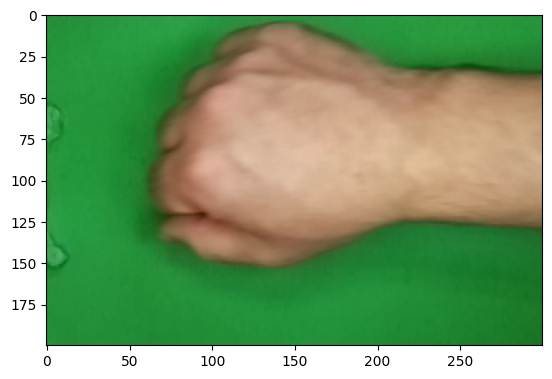

In [4]:
plt.figure()
print(random.choice(['a','b','c']))
folder = os.path.join(path, random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
print(img_name)
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Transformation and data augmentation

In [27]:
# no need to resize since all images have the same dimension (?)
# validation set only transformed to tensor
# training set augmented with random transformations

val_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=45),
])

# DataLoader creation

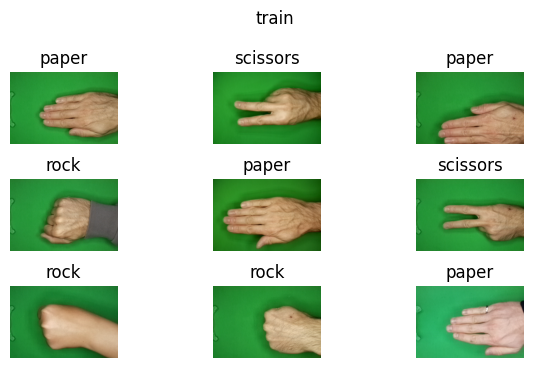

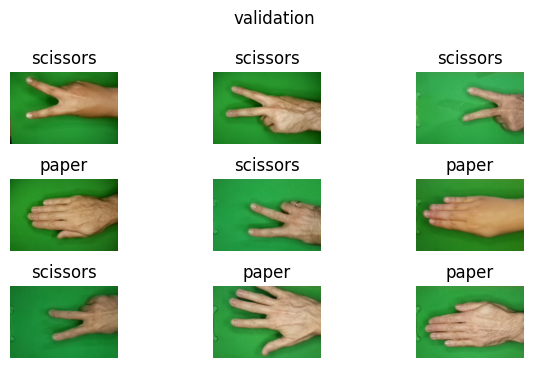

In [28]:
batch_size = 9

dataset = datasets.ImageFolder(root=path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size)

def show_batch(dl, title=None):
    img, lbl = next(iter(dl))
    col = math.floor(math.sqrt(len(img)))
    row = col+1
    for i in range(len(img)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        ax.set_title(dataset.classes[lbl[i]])
        ax.axis('off')
        plt.imshow(img[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(train_dl, 'train')
show_batch(val_dl, 'validation')

# SomeNet

In [29]:
class SomeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6,16,3)
        self.middleconv2 = nn.Conv2d(16,16,3)
        self.norm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,64,3)
        self.norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,120,3)
        self.middleconv4 = nn.Conv2d(120,120,3)
        self.norm4 = nn.BatchNorm2d(120)

        self.fc1 = nn.Linear(162*10*10,120)
        self.fc2 = nn.Linear(120,64)
        self.fc3 = nn.Linear(64,3)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool(F.relu(self.norm2(self.middleconv2(x))))
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.middleconv4(x)))

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
net = SomeNet()
net.to(device)

img,lbl=next(iter(train_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])
Size of the output tensor is torch.Size([9, 3])


In [31]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    numClasses = len(class_names)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 1000000
    best_aucs = np.array([best_auc, best_auc])

    train_loss_time = []
    val_loss_time = []

    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for img,lbl in dataloaders[phase]:
                inputs = img.to(device).float()
                labels = lbl.to(device)


                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batch_size,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batch_size]=labels.cpu().numpy()
                contSamples+=batch_size

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
                train_loss_time.append(epoch_loss)
            else:
                val_loss_time.append(epoch_loss)

            #Compute the AUCs at the end of the epoch
            aucs=np.array([epoch_loss,epoch_loss])#computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc < best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    plt.plot(train_loss_time, 'bo-', label='train loss')
    plt.plot(val_loss_time, 'r+-', label='val loss')
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/19
----------
train Loss: 0.3644 AUC mel: 0.3644 sk: 0.3644 avg: 0.3644
val Loss: 0.3133 AUC mel: 0.3133 sk: 0.3133 avg: 0.3133

Epoch 1/19
----------
train Loss: 0.1188 AUC mel: 0.1188 sk: 0.1188 avg: 0.1188
val Loss: 0.1216 AUC mel: 0.1216 sk: 0.1216 avg: 0.1216

Epoch 2/19
----------
train Loss: 0.0678 AUC mel: 0.0678 sk: 0.0678 avg: 0.0678
val Loss: 0.0572 AUC mel: 0.0572 sk: 0.0572 avg: 0.0572

Epoch 3/19
----------
train Loss: 0.0340 AUC mel: 0.0340 sk: 0.0340 avg: 0.0340
val Loss: 0.0347 AUC mel: 0.0347 sk: 0.0347 avg: 0.0347

Epoch 4/19
----------
train Loss: 0.0339 AUC mel: 0.0339 sk: 0.0339 avg: 0.0339
val Loss: 0.2010 AUC mel: 0.2010 sk: 0.2010 avg: 0.2010

Epoch 5/19
----------
train Loss: 0.0477 AUC mel: 0.0477 sk: 0.0477 avg: 0.0477
val Loss: 0.0332 AUC mel: 0.0332 sk: 0.0332 avg: 0.0332

Epoch 6/19
----------
train Loss: 0.0070 AUC mel: 0.0070 sk: 0.0070 avg: 0.0070
val Loss: 0.0252 AUC mel: 0.0252 sk: 0.0252 avg: 0.0252

Epoch 7/19
----------
train Loss: 0.0005 

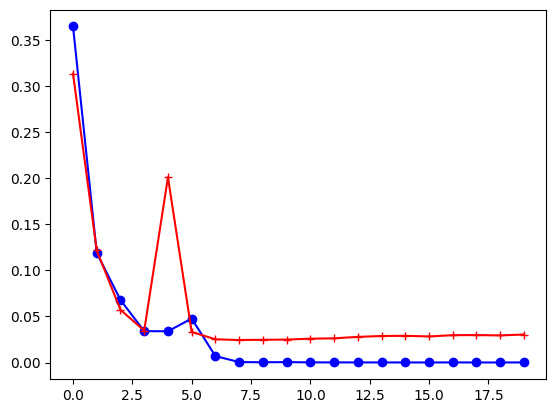

In [32]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
#optimizer_ft = optim.SGD(customNet.parameters(), lr=1e-3, momentum=0.9)
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3) # Adam seems a better option
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


image_datasets = {'train' : train_dataset, 'val': val_dataset}

dls = {'train' : train_dl, 'val': val_dl}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = dataset.classes
net = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


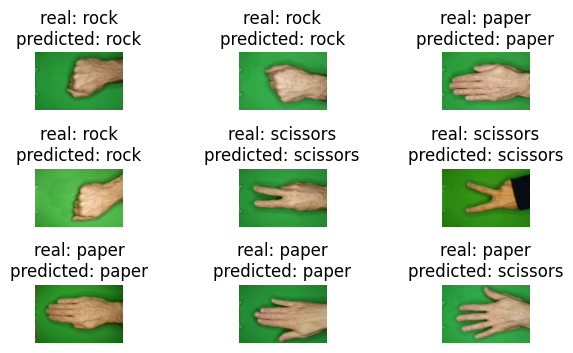

In [20]:
img,lbl=next(iter(train_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)

def show_batch2(x, y, yh):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        ax.set_title('real: ' + dataset.classes[int(y[i])]+'\npredicted: ' + dataset.classes[int(np.argmax(yh[i]))])
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    plt.show()
if (device=='cpu'):
    show_batch2(img,lbl,outputs)
else:
    show_batch2(img,lbl,outputs.cpu().numpy())


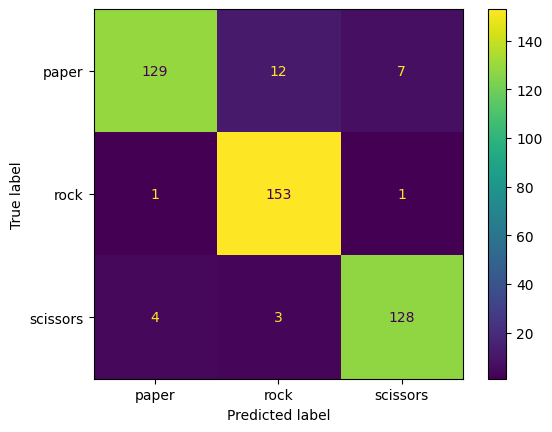

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y = []
y_hat = []

with torch.set_grad_enabled(False):
    for img, lbls in val_dl:
        output = net(img.to(device).float()).to('cpu').float()
        y.extend(lbls)
        pred = output.data.max(1, keepdim=True)[1]
        y_hat.extend(pred)

cm = confusion_matrix(y, y_hat, labels=range(len(class_names)))
ConfusionMatrixDisplay(cm,display_labels=class_names).plot()

In [13]:
print(class_names)

['paper', 'rock', 'scissors']
